# Tutorial for Boundless DAS (v1.0)

Author: Zhengxuan Wu (wuzhengx@stanford.edu)  
Last Update: 06/17/2023

## *Setups and Analysis, Federated Model Steering and Alignment Sharing*

### Introduction
We notice that we used an internal version (Stanford personales only) of Alpaca-7B model in the paper, which is not publicly avaliable. This greatly reduces the reproducibility of this paper. We thus provide this script to fetch an example model from huggingface model hub, and setup the training environment + verification of a single datapoint. 

Note that we do not hookup this script for our training script to that you can load specialized models later on.

### What does this file cover?
- Download a HF model.
- Cast it into an alignable version (without any processing, simply downcasting).
- Reproduce one example from the paper about boundless DAS training.
- **A guide to share rotation matrix with others.**

In [1]:
from transformers import (
    set_seed,
    AutoConfig,
    get_linear_schedule_with_warmup,
    AutoTokenizer,
    AutoModelForCausalLM
)
import seaborn as sns
from datasets import Dataset
import os, random, argparse, sys, torch
from models.configuration_alignable_model import AlignableLlamaConfig
from counterfactual_datasets.price_tagging_game import factual_sampler, bound_alignment_sampler, lower_bound_alignment_example_sampler
from trainer import Aligner, CACHE_DIR
import counterfactual_datasets.price_tagging_game as price_tagging_game
from torch.utils.data import DataLoader, SequentialSampler
from models.modelings_alignable import AutoAlignableModel

from transformers.utils import logging
logging.set_verbosity_info()
logger = logging.get_logger("transformers")

#### Step 1: Load a HF model, Verify Its Task Performance, and Save It in the Disk for Alignment
This is **super important** that is verifying the task performance! Sometimes, a little bug in the tokenizer (e.g., how SOS and EOS tokens are formulated) can largely change your expectation in performance. This is simply as the result of supervised tuning.

In [ ]:
RUN_ONCE_ALREADY = True

In [20]:
if not RUN_ONCE_ALREADY:
    tokenizer = AutoTokenizer.from_pretrained(
        "sharpbai/alpaca-7b-merged",
        cache_dir="../.cache_dir/"
    )
    model = AutoModelForCausalLM.from_pretrained(
        "sharpbai/alpaca-7b-merged",
        cache_dir="../.cache_dir/",
        torch_dtype=torch.bfloat16
    )
    _ = model.to("cuda")

    raw_prealign = factual_sampler(
        tokenizer,
        5000,
        game="pricing_tag"
    )
    prealign_dataset = Dataset.from_dict(
        {
            "input_ids": raw_prealign[0], 
            "labels": raw_prealign[1],
        }
    ).with_format("torch")
    prealign_dataloader = DataLoader(
        prealign_dataset, batch_size=8
    )

    total_count = 0
    correct_count = 0
    model.eval()
    with torch.no_grad():
        for step, inputs in enumerate(tqdm(prealign_dataloader)):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to(model.device)

            # aligning forward!
            outputs = model(
                input_ids=inputs['input_ids'],
                labels=inputs['labels'],
            )

            actual_test_labels = inputs['labels'][:, -1]
            pred_test_labels = torch.argmax(outputs.logits[:, -1], dim=-1)

            correct_labels = (actual_test_labels==pred_test_labels)

            total_count += len(correct_labels)
            correct_count += correct_labels.sum().tolist()
    current_acc = round(correct_count/total_count, 2)
    print(f"[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: {current_acc}")
    
    # Now, we save this model to a separate folder for the alignment script to load. 
    # If you have your own model with your own dataset, you can follow the rest of 
    # steps here to create a DAS config file.
    tokenizer.save_pretrained("../alpaca_7b/")
    model.save_pretrained("../alpaca_7b/")

    # we create a alignment config here. you want to change to your settings later on.
    das_config = AlignableLlamaConfig()
    das_config.save_pretrained("../alpaca_7b/das_config")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:42<00:00, 14.72it/s]

[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: 0.92


**===== STOP HERE AND READ =====**

Now, you have the model to align! And if your code above run without an error, it probably means you have all the env stuff set up. Great! So, ...

If your purpose is to run alignment script in a separate process, please read the `run_alignment.py` and you can close this notebook now. If you want to see example code about how to load alignable model, how to run trainer in a notebook, you can continue to read this notebook. We recommend you run the `*py` script, and the notebook is more like a playground instead.

**===== STOP HERE AND READ =====**

#### Step 2: Reproducing One Boundless DAS Result from Our Paper

In [2]:
set_seed(42)

###################
# data loaders
###################
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path="../alpaca_7b/",
    cache_dir=CACHE_DIR
)

raw_data = bound_alignment_sampler(
    tokenizer,
    10000,
    [lower_bound_alignment_example_sampler]
)

raw_train = (
    raw_data[0][:8000], 
    raw_data[1][:8000], 
    raw_data[2][:8000],
    raw_data[3][:8000]
)
raw_eval = (
    raw_data[0][8000:9000], 
    raw_data[1][8000:9000], 
    raw_data[2][8000:9000],
    raw_data[3][8000:9000]
)
raw_test = (
    raw_data[0][9000:], 
    raw_data[1][9000:], 
    raw_data[2][9000:],
    raw_data[3][9000:]
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0], 
        "source_input_ids": raw_train[1],
        "labels": raw_train[2],
        "intervention_ids": raw_train[3],
    }
).with_format("torch")
train_dataloader = DataLoader(
    train_dataset, batch_size=16,
)
eval_dataset = Dataset.from_dict(
    {
        "input_ids": raw_eval[0], 
        "source_input_ids": raw_eval[1],
        "labels": raw_eval[2],
        "intervention_ids": raw_eval[3],
    }
).with_format("torch")
eval_dataloader = DataLoader(
    eval_dataset, batch_size=16,
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": raw_test[0], 
        "source_input_ids": raw_test[1],
        "labels": raw_test[2],
        "intervention_ids": raw_test[3],
    }
).with_format("torch")
test_dataloader = DataLoader(
    test_dataset, batch_size=16,
)

loading file tokenizer.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


First important check: since we randomly sample training data, although very unlikely due to the probability constraints from random combination of three numbers with 2 decimal points, we can check how many unique inputs we have during training, testing and eval.

In [3]:
unique_train = set([tuple(e) for e in raw_train[0]])
len(unique_train)

8000

In [4]:
unique_all = set([tuple(e) for e in raw_train[0]] + [tuple(e) for e in raw_eval[0]] + [tuple(e) for e in raw_test[0]])
len(unique_all)

10000

Now, we are ready to align with this very simple dataset! Let's load back our model but with the alignable model architecture created by us.

**Very Important**: If you want to load the model as `torch.bfloat16`, you are required to **replace** two torch files under your torch folder of the current running conda environment.

To do this, a very hacky way is to first run the following script, and look at the place where the error is thrown. That is the place of the files you want to replace. With this, you can modify the following two bash command to replace your files. We have not fully tested this, but it seems like our replacing files are also compatible with torch 3.9.

In [8]:
#########################################
# DO NOT RUN UNLESS YOU READ LINES ABOVE
!cp ./torch3.8_overwrite/init.py /opt/conda/envs/BoundlessDAS/lib/python3.9/site-packages/torch/nn/
!cp ./torch3.8_overwrite/parametrizations.py /opt/conda/envs/BoundlessDAS/lib/python3.9/site-packages/torch/nn/utils/
#########################################

Load the alignable model and others; then, create the aligner

In [ ]:
das_config = AlignableLlamaConfig.from_pretrained(
    os.path.join("../alpaca_7b/", "das_config")
)
alignment_config = {
    'layer': das_config.das_layer,
    "token_range" : [
        das_config.das_token_range[0], 
        das_config.das_token_range[1], 
    ]
}
model = AutoAlignableModel.from_pretrained(
    "../alpaca_7b/",
    alignment_config=alignment_config,
    torch_dtype=torch.bfloat16,
    cache_dir=CACHE_DIR
)
_ = model.to("cuda") # first GPU

# set off the gradients among all other layers.
for name, param in model.named_parameters():
    if "rotate_layer" not in name and "intervention_boundaries" not in name:
        param.requires_grad = False
    else:
        logger.info(f"Requiring gradients on layer: {name}")
t_total = int(len(train_dataloader) * 3)
warm_up_steps = 0.1 * t_total
optimizer = torch.optim.Adam(
    [{'params': model.model.rotate_layer.parameters()},
    {'params': model.model.intervention_boundaries, 'lr': 1e-2}],
    lr=1e-3
)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps,
    num_training_steps=t_total
)
# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = (actual_test_labels==pred_test_labels)
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count/total_count, 2)
    return {"accuracy" : accuracy}

model_type = AutoConfig.from_pretrained(
    "../alpaca_7b/"
).architectures[0]

run_name = f"{model_type}.task.pricing_tag_lb."\
           f"seed.42.intl.{alignment_config['layer']}.intr.{alignment_config['token_range'][0]}."\
           f"{alignment_config['token_range'][1]}"
if not os.path.exists("./results_tmp/"):
    os.mkdir("./results_tmp/")
os.environ["WANDB_PROJECT"] = f"Boundless-DAS"
output_dir = os.path.join("./results_tmp/", run_name)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
aligner = Aligner(
    model,
    logger=logger,
    is_wandb=False,
    is_master=True,
    n_gpu=1,
    model_name=run_name,
    device="cuda",
    compute_metrics=compute_metrics
)

Train Boundless DAS

**Note that this is a simplied setting of what we've used in the paper to make the tutorial easier to follow.** The expectation is that, after the training is finished, we want to find an alignment of lower bound check within the Alpaca model. 

**Note that it is okay if the loss is go below zero!** since we optimize for smaller intervention site which could go below zero since we optimize for smaller loss.

In [11]:
aligner.train(
    train_dataloader, 
    eval_dataloader, 
    test_dataloader,
    optimizer, scheduler, 
    log_step=10, 
    valid_steps=500,
    output_dir=output_dir, 
    epochs=3, 
    gradient_accumulation_steps=4,
)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [24:48<00:00, 496.13s/it]
Training is finished ...


#### Step 3: Analyzing Results

We load the best rotation matrix saved in disk.

In [19]:
checkpoint_state_dict = torch.load(
    f"./results_tmp/LlamaForCausalLM.task.pricing_tag_lb.seed.42.intl.15.intr.80.81/pytorch-rotate-best.bin"
)

Let's look at what does this file contain.

In [20]:
checkpoint_state_dict

{'rotate_layer': OrderedDict([('parametrizations.weight.original',
               tensor([[ 0.0070, -0.0118,  0.0208,  ...,  0.0044,  0.0110,  0.0047],
                       [-0.0074, -0.0139, -0.0033,  ...,  0.0156,  0.0061, -0.0041],
                       [-0.0008,  0.0042,  0.0070,  ...,  0.0238,  0.0288, -0.0210],
                       ...,
                       [-0.0130, -0.0192, -0.0074,  ..., -0.0121,  0.0091, -0.0216],
                       [ 0.0337, -0.0045,  0.0143,  ...,  0.0008, -0.0273,  0.0261],
                       [-0.0168,  0.0146, -0.0071,  ...,  0.0160,  0.0156, -0.0077]],
                      device='cuda:0', dtype=torch.bfloat16))]),
 'intervention_boundaries': Parameter containing:
 tensor([ 0.1177, -0.6562], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True),
 'temperature': Parameter containing:
 tensor(16.8750, dtype=torch.bfloat16)}

Besides the rotation matrix, you can also see the intervention boundaries (in percentage) which marks the best setting for intervention accuracy. It is worth to note that this is boundary with the best evaluation metrics, not the lowest it can go in terms of maintaining a fairly good evaluation metrics. There is a subtle distinct here :).

In [21]:
checkpoint_state_dict = torch.load(
    f"./results_tmp/LlamaForCausalLM.task.pricing_tag_lb.seed.42.intl.15.intr.80.81/pytorch-rotate-last.bin"
)

In [22]:
checkpoint_state_dict

{'rotate_layer': OrderedDict([('parametrizations.weight.original',
               tensor([[ 0.0070, -0.0118,  0.0208,  ...,  0.0044,  0.0110,  0.0047],
                       [-0.0149, -0.0139, -0.0033,  ...,  0.0156,  0.0061, -0.0041],
                       [-0.0039,  0.0037,  0.0070,  ...,  0.0238,  0.0288, -0.0210],
                       ...,
                       [-0.0087, -0.0134,  0.0008,  ..., -0.0121,  0.0091, -0.0216],
                       [ 0.0327, -0.0143,  0.0172,  ..., -0.0013, -0.0273,  0.0261],
                       [-0.0171,  0.0106, -0.0172,  ...,  0.0198,  0.0132, -0.0077]],
                      device='cuda:0', dtype=torch.bfloat16))]),
 'intervention_boundaries': Parameter containing:
 tensor([ 0.1069, -1.6328], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True),
 'temperature': Parameter containing:
 tensor(0.2002, dtype=torch.bfloat16)}

The last rotation matrix is with slightly smaller site, but the temperature is much lower. As a result, the learned boundary is very sharp here.

**Note that in the current paper, we report the best rotation matrix not the last one!** This creates an ambiguity in terms of intervention since it means the intervention can be **soft**. But the **Softness** can give nice properties, which is left to you to think about!

Let's visualize both boundaries!

<Axes: >

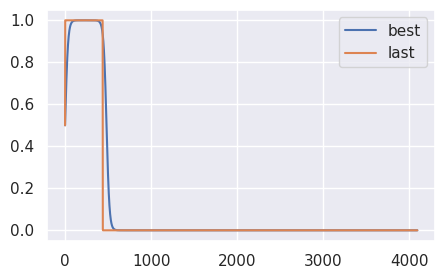

In [25]:
def sigmoid_boundary_sigmoid(_input, boundary_x, boundary_y, temperature):
    return torch.sigmoid((_input - boundary_x) / temperature) * \
        torch.sigmoid((boundary_y - _input) / temperature)
sns.set(rc={'figure.figsize':(5, 3)})
sns.lineplot(
    x=torch.arange(0, 4096), 
    y=sigmoid_boundary_sigmoid(torch.arange(0, 4096), 0, 4096*0.1177, 16.8750),
    label='best'
)
sns.lineplot(
    x=torch.arange(0, 4096), 
    y=sigmoid_boundary_sigmoid(torch.arange(0, 4096), 0, 4096*0.1069, 0.2002),
    label='last'
)

The above is the learned boundary! **Essentially, this is a low pass filter on the hidden representation.**

Now, with this rotation matrix, and learned intervention boundary, we can finally start to **steer** LLM's behavior following our aligned causal variables - the lower bound check!

Instead of loading the best rotation matrix, we are using the last one to verify.

In [26]:
base_input = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Please say yes only if it costs between 3.49 and 8.49 dollars, otherwise no.

### Input:
1.50 dollars

### Response:
"""

The output of this input should be **No** since **1.50 <= 3.49**. Let's check Alpaca's output.

In [27]:
input_ids = tokenizer(base_input, return_tensors="pt").input_ids.to("cuda")
attention_mask = tokenizer(base_input, return_tensors="pt").attention_mask.to("cuda")
model.eval()
outputs = model(
    input_ids,
    attention_mask=attention_mask
)
pred_labels = torch.argmax(outputs.logits[:, -1], dim=-1)
generated_tokens = tokenizer.decode(pred_labels[0])

afc_1 = tokenizer.convert_tokens_to_ids("Yes")
afc_2 = tokenizer.convert_tokens_to_ids("No")
afc_1_prob = outputs.logits[:, -1][0][afc_1]
afc_2_prob = outputs.logits[:, -1][0][afc_2]
if afc_1_prob > afc_2_prob:
    afc = "Yes"
else:
    afc = "No"
print(f"afc label = {afc} ({afc_1_prob}/{afc_2_prob}) ; pred label = {generated_tokens}")

afc label = No (20.75/21.125) ; pred label = No


Now, let's intervene it to let the model to output **Yes** with our learned rotation matrix. 

The issue with **1.50** is that it is below the lower bound. So, we simply need another example that is above the lower bound. Let's take this one.

In [28]:
source_input = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Please say yes only if it costs between 2.51 and 7.51 dollars, otherwise no.

### Input:
9.49 dollars

### Response:
"""
input_ids = tokenizer(source_input, return_tensors="pt").input_ids.to("cuda")
attention_mask = tokenizer(source_input, return_tensors="pt").attention_mask.to("cuda")
model.eval()
outputs = model(
    input_ids,
    attention_mask=attention_mask,
)
pred_labels = torch.argmax(outputs.logits[:, -1], dim=-1)
generated_tokens = tokenizer.decode(pred_labels[0])

afc_1 = tokenizer.convert_tokens_to_ids("Yes")
afc_2 = tokenizer.convert_tokens_to_ids("No")
afc_1_prob = outputs.logits[:, -1][0][afc_1]
afc_2_prob = outputs.logits[:, -1][0][afc_2]
if afc_1_prob > afc_2_prob:
    afc = "Yes"
else:
    afc = "No"
print(f"afc label = {afc} ({afc_1_prob}/{afc_2_prob}) ; pred label = {generated_tokens}")

This should output **No** as well since **9.49** is above both bounds! Now, since we aligned the lower bound check, we should be able to intervene the first example (lower bound check = False) with hidden states from the second example (lower bound check = True) representing the lower bound check. **As a result, we should be able to flip the output label.**

In [35]:
source_hidden_states = model(
    input_ids=tokenizer(source_input, return_tensors="pt").input_ids.to("cuda"),
    output_rotated_hidden_states_only=True
).rotated_hidden_states
outputs = model(
    input_ids=tokenizer(base_input, return_tensors="pt").input_ids.to("cuda"),
    source_hidden_states=source_hidden_states,
    intervention_ids=torch.tensor([0]).to("cuda"),
)
pred_labels = torch.argmax(outputs.logits[:, -1], dim=-1)
generated_tokens = tokenizer.decode(pred_labels[0])

afc_1 = tokenizer.convert_tokens_to_ids("Yes")
afc_2 = tokenizer.convert_tokens_to_ids("No")
afc_1_prob = outputs.logits[:, -1][0][afc_1]
afc_2_prob = outputs.logits[:, -1][0][afc_2]
if afc_1_prob > afc_2_prob:
    afc = "Yes"
else:
    afc = "No"
print(f"afc label = {afc} ({afc_1_prob}/{afc_2_prob}) ; pred label = {generated_tokens}")

afc label = Yes (21.375/20.25) ; pred label = Yes


**Yay! We successfully flip the label!** Within our paper, we should more experiments and have robustness checks. You can refer there for additional information if you ever doubt the result.

#### Step 4: Sharing Rotation Matrix and Alignment Config

A **very promising future** of representation-based alignment search is **federated model steering** and **community sharing**! Let me elabrate them a little further, and with a specific example (i.e., sharing the lower bound boolean alignment through huggingface).

- **federated model steering:** we all know prompts can steer model behaviors. However, prompt steering is not federated (i.e., users can steer the model into a harmful mode through prompt hacking). With intervention and representation-based alignment, we can control model representations through the causal lens and steer the model to behave in certain ways (e.g., anchoring the lower bound check to be always returing TRUE).

- **community sharing:** the rotation matrix and learned boundary learned with boundless DAS can be shared through huggingface easily. This means, given a LLM, the community can do alignment and share meaningful alignment simply with the alignment config and learned roation matrix! This is just like sharing the prompt. Imagine a world where people find the alignment for gender. Then, we can do federated model steering!

In [4]:
from huggingface_hub import notebook_login
from huggingface_hub import HfApi
notebook_login()

sharing the rotation matrix

In [ ]:
api = HfApi()
api.upload_file(
    path_or_fileobj="./results_tmp/LlamaForCausalLM.task.pricing_tag_lb.seed.42.intl.15.intr.80.81/pytorch-rotate-best.bin",
    path_in_repo="pytorch-rotate-best.bin",
    repo_id="zhengxuanzenwu/alpaca-price-tagging-lower-bound",
    repo_type="model",
)

sharing the alignment config (layer and token position)

In [ ]:
api.upload_file(
    path_or_fileobj="../alpaca_7b/das_config/config.json",
    path_in_repo="config.json",
    repo_id="zhengxuanzenwu/alpaca-price-tagging-lower-bound",
    repo_type="model",
)

You can find the rotation matrix and alignment config for this file here:   
https://huggingface.co/zhengxuanzenwu/alpaca-price-tagging-lower-bound/tree/main

You can download using huggingface API by following examples here:   
https://huggingface.co/docs/huggingface_hub/guides/download

**Thank you** for your attention! If you like this tutorial, feel free to build on it, and share it with others!